# Анализ лояльности пользователей Яндекс Афиши

Автор: Насретдинов А.Р. <br>
Дата: 01.26

# https://github.com/eldonborg-down/module2_project

### Цели и задачи проекта

Проанализировать поведение пользователей Я.Афиши, выяснить какие пользователи возвращаютс к сервису, а какие покидают, выявить их паттерн.  
Эти результаты помогут повысить уровень клиентоориентированности и долю вернувшихся клиентов.

### Описание данных

user_id — уникальный идентификатор пользователя, совершившего заказ;<br>
device_type_canonical — тип устройства, с которого был оформлен заказ (mobile — мобильные устройства,desktop — стационарные) <br> 
order_id — уникальный идентификатор заказа;<br>
order_dt — дата создания заказа (используйте данные created_dt_msk );<br>
order_ts — дата и время создания заказа (используйте данные created_ts_msk );<br>
currency_code — валюта оплаты;<br>
revenue — выручка от заказа;<br>
tickets_count — количество купленных билетов;<br>
days_since_prev — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;<br>
event_id — уникальный идентификатор мероприятия;<br>
service_name — название билетного оператора;<br>
event_type_main — основной тип мероприятия (театральная постановка, концерт и так далее);<br>
region_name — название региона, в котором прошло мероприятие;<br>
city_name — название города, в котором прошло мероприятие.<br>

### Содержимое проекта

1. [Загрузка и знакомство с данными](#section-1)
2. [Предобработка данных](#section-2)
3. [Создание профиля пользователя](#section-3)
4. [Проверка данных профиля и наличия аномалий](#section-4)
5. [Исследовательский анализ данных](#section-5)
6. [Анализ взвращения пользователя по сегментам](#section-6)
7. [Выручка относительно состава заказа](#section-7)
8. [Влияние количества билетов на возвращение клиента](#section-8)
9. [Временные интервалы и зависимости](#section-9)
10. [Корреляционный анализ](#section-10)
11. [Выводы и рекомендации](#section-11)

<a id="section-1"></a>
## 1. Загрузка данных и знакомство с ними

In [1]:
!pip install sqlalchemy

In [2]:
!pip install psycopg2

In [3]:
!pip install phik

In [4]:
import pandas as pd
import numpy as np
import phik
from phik import resources, report
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

In [5]:

# Загружаем переменные из .env
load_dotenv()

# Формируем словарь конфигурации
db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PWD'),
    'host': os.getenv('DB_HOST'),
    'port': int(os.getenv('DB_PORT')),  # преобразуем в число
    'db': os.getenv('DB_NAME')
}


In [6]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Загружаем необходимые библиотеки и подключаемся к хранилищу данных

In [7]:
engine = create_engine(connection_string)

In [8]:
query = '''
SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk as order_dt,
    created_ts_msk as order_ts,
    currency_code,
    revenue,
    tickets_count,
    EXTRACT(DAY FROM (created_dt_msk - LAG(created_dt_msk) OVER (PARTITION BY user_id ORDER BY created_dt_msk)))
        AS days_since_prev,
    e.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p 
INNER JOIN afisha.events AS e  ON p.event_id= e.event_id
INNER JOIN afisha.city AS c ON e.city_id = c.city_id 
INNER JOIN afisha.regions AS r ON c.region_id= r.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id
'''

In [9]:
df = pd.read_sql_query(query, con=engine)

Фильтруем и создаем в БД необходимую для анализа таблицу.

Проведем первичный анализ таблицы, выявим необходимые шаги в дальнейшем. Зафиксирууем основную информацию.

In [10]:
df.head(4)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск


In [11]:
df.shape

(290611, 15)

In [12]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object

Типы данных в каждом столбце подходят под описание, разве что можно немного сократить размерность у выручки, что мы сейчас и сделаем. 

In [13]:
df['revenue'] = df['revenue'].astype('float32')

In [14]:
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float32
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
dtype: object

Размерность поля выручки изменена

In [15]:
df.describe()

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397730816,625.584412,2.754311,3.222381,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760002,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.849998,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010010,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130005,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.539062,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.627930,1.170620,11.350509,147423.078841


По статистике числовых столбцов можно выделить одну занимательную вещь. В
столбце revenue присутствуют отрицательные значения, необходимо выяснить ошбочные ли это записи или были продажи приносившие убыток организации. Так же макимальная выручка с одного заказа составляет 81174, что вызывает сомнения, не выброс ли это,необходимо будет разобраться какое количество билетов было куплено в этом заказе и т.д.

In [16]:
print(df.isnull().sum())  # число NaN по столбцам
print(df.isnull().mean())  # доля NaN

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64
user_id                  0.000000
device_type_canonical    0.000000
order_id                 0.000000
order_dt                 0.000000
order_ts                 0.000000
currency_code            0.000000
revenue                  0.000000
tickets_count            0.000000
days_since_prev          0.075472
event_id                 0.000000
event_name               0.000000
event_type_main          0.000000
service_name             0.000000
region_name              0.000000
city_name                0.000000
dtype: float

Пропуски имеются только в столбце количества дней, что логично, пользователи могут совершить только один заказ, в котором и будет образован NAN, эти пропуски можно оставить.

__Вывод:__ по первому взгляду на данные: Данные структурированы, полны, и имеют необходимый формат значений в каждом столбце 

<a id="section-2"></a>
## 2. Предобработка данных

In [17]:
df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

Оплаты заказов были в двух валютах: Рублях и тенге. Приведем выручку к единой валюте — российскому рублю.<br>
Для этого подгрузим таблицу соотношения курса относительно даты к тенге-руб. Значения в рублях представлено для 100 тенге.

In [18]:
rates_df = pd.read_csv('final_tickets_tenge_df.csv')

In [19]:
rates_df.dtypes

data        object
nominal      int64
curs       float64
cdx         object
dtype: object

In [20]:
rates_df['data'] = pd.to_datetime(rates_df['data'])
rates_df['nominal'] = rates_df['nominal'].astype('int8')
rates_df['curs'] = rates_df['curs'].astype('float32')

Конвертируем в дату

In [21]:
rates_df.dtypes

data       datetime64[ns]
nominal              int8
curs              float32
cdx                object
dtype: object

In [22]:
# 3. Соединение с таблицей курсов по ключу - дате
df = pd.merge(
    df,
    rates_df,
    left_on='order_dt',
    right_on='data',
    how='left'
)

In [23]:
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] / row['nominal'] * row['curs'] 
    if row['currency_code'] == 'kzt' 
    else row['revenue'],
    axis=1
) #Создаем новый столбец revenue_rub в котором рассчитываем выгоду в рублях по всем строкам

In [24]:
df.loc[df['currency_code'] == 'kzt'].tail(5) #вывод последних значений оплата которых была тенге

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx,revenue_rub
290484,ffc24188a1d58f2,mobile,6862648,2024-07-11,2024-07-11 12:39:48,kzt,4735.520020,2,20.0,538828,603c97c6-b64f-4ec6-8de9-20b95c20b2b5,концерты,Билеты без проблем,Верхоречная область,Серебрянка,2024-07-11,100,18.2738,kzt,865.359452
290485,ffc24188a1d58f2,mobile,6763294,2024-09-05,2024-09-05 12:07:00,kzt,4735.520020,2,56.0,538828,603c97c6-b64f-4ec6-8de9-20b95c20b2b5,концерты,Билеты без проблем,Верхоречная область,Серебрянка,2024-09-05,100,18.4217,kzt,872.363269
290486,ffc24188a1d58f2,mobile,3984021,2024-09-06,2024-09-06 19:20:03,kzt,1849.410034,1,1.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-09-06,100,18.5504,kzt,343.072955
290488,ffc4133fbba20f4,mobile,8493869,2024-06-21,2024-06-21 14:04:34,kzt,3698.830078,2,NaN,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-21,100,18.5791,kzt,687.209326
290489,ffc4133fbba20f4,mobile,8493898,2024-06-21,2024-06-21 13:41:39,kzt,3698.830078,2,0.0,533803,0686ac7b-6f3e-4177-bb73-16b54acd1223,концерты,Мой билет,Шанырский регион,Широковка,2024-06-21,100,18.5791,kzt,687.209326


Подгрузили новый датафрейм rates_df с курсом по дате и из этих данных преобразовали новый столбец revenue_rub который отображает выручку в рублях по всем строкам вне зависимости валюты currency_code. 

In [25]:
df = df.drop(columns=['data', 'nominal', 'curs', 'cdx']) #дропаем ненужные в дальнейшем столбцы

In [26]:
print(df['event_type_main'].unique())
print(df['service_name'].unique())

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']


Номинальные данные проверены, дубликатов по названиям не обнаружено, но приведем нормализацию в разделе названия сервиса.

In [27]:
df['service_name'] = df['service_name'].str.strip().str.lower() #Убираем возможные двойные пробелы и заглавные буквы
df['service_name'] = df['service_name'].str.replace(r'\s+', ' ', regex=True) #Исправляем возможные множественные пробелы между словами 
print(df['service_name'].unique()) #Проверим итоговую нормализацию

['край билетов' 'мой билет' 'за билетом!' 'лови билет!'
 'билеты без проблем' 'облачко' 'лучшие билеты' 'прачечная' 'быстробилет'
 'дом культуры' 'весь в билетах' 'билеты в руки' 'тебе билет!'
 'show_ticket' 'городской дом культуры' 'яблоко' 'билет по телефону'
 'выступления.ру' 'росбилет' 'шоу начинается!' 'мир касс' 'восьмёрка'
 'телебилет' 'crazy ticket!' 'реестр' 'быстрый кассир' 'карандашру'
 'радио ticket' 'дырокол' 'вперёд!' 'кино билет' 'цвет и билет' 'зе бест!'
 'тех билет' 'лимоны' 'билеты в интернете']


In [28]:
df[['revenue', 'tickets_count', 'days_since_prev', 'event_id', 'revenue_rub']].describe()

,revenue,tickets_count,days_since_prev,event_id,revenue_rub
count,290611.000000,290611.000000,268678.000000,290611.000000,290611.000000
mean,625.584412,2.754311,3.222381,438019.834992,555.571986
std,1227.627930,1.170620,11.350509,147423.078841,875.498165
min,-90.760002,1.000000,0.000000,4436.000000,-90.760002
25%,116.849998,2.000000,0.000000,361772.000000,113.970001
50%,356.010010,3.000000,0.000000,498275.000000,351.140015
75%,810.130005,4.000000,1.000000,546287.000000,802.049988
max,81174.539062,57.000000,148.000000,592325.000000,81174.539062


Просмотрим статистические показатели числовых столбцов.  
tickets_count - однородные данные, типичная продажа билетов в размере 1-4шт, бывают и групповые закупки как 57шт.  
days_since_prev - Большинство событий идут друг за другом без перерыва, есть длинные паузы до 148 дней, но они редки  
revenue_rub - много малых значений + редкие выбросы, отрицательных значений - потенциальная проблема данных.

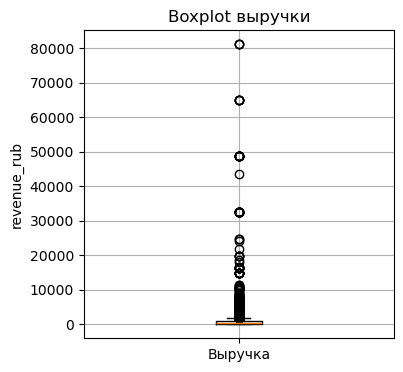

In [29]:
plt.figure(figsize=(4, 4))
plt.boxplot(df['revenue_rub'], labels=['Выручка'])
plt.title('Boxplot выручки')
plt.ylabel('revenue_rub')
plt.grid(True)
plt.show()

In [30]:
df[df['revenue_rub'] > 50000].tail(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
122337,5b5714894bd0517,mobile,4113506,2024-08-03,2024-08-03 22:35:14,rub,64939.628906,4,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,Североярская область,Озёрск,64939.628906
122338,5b5714894bd0517,mobile,4113535,2024-08-03,2024-08-03 22:36:13,rub,81174.539062,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,Североярская область,Озёрск,81174.539062
183754,96368e5714d1673,mobile,8067453,2024-08-24,2024-08-24 13:56:40,rub,81174.539062,5,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,Североярская область,Озёрск,81174.539062
198761,a6021dd115eba1e,mobile,7150734,2024-09-15,2024-09-15 20:55:15,rub,64939.628906,4,0.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,Североярская область,Озёрск,64939.628906
235142,c9d333921d46129,mobile,4299860,2024-09-12,2024-09-12 06:20:33,rub,64939.628906,4,1.0,552398,b443dc5a-fff2-4b69-8684-0719fff49b59,концерты,облачко,Североярская область,Озёрск,64939.628906


In [31]:
df[df['revenue_rub'] > 50000]['event_id'].unique().shape[0] #Один единственный ивент собирает выручку более 50тыс

1

Разберем аномалии с высокой выручкой, для этого вывели несколько значений где выручка составила более 50000, обнаружили что один ивент = 552398 с аномально высокой выручкой по каждой из транзакций.

In [32]:
print(f'Общее количество транзакций по ивенту 552398: {df[df['event_id'] == 552398]['revenue_rub'].count()}')
print(f'Общее количество транзакций с выручкой больше 15000 руб. по ивенту 552398: {df[(df["event_id"] == 552398) & (df["revenue_rub"] > 15000)]["revenue_rub"].count()}')
print(f'Общая сумма выручки ивента 552398: {df[df['event_id'] == 552398]['revenue_rub'].sum()}')

Общее количество транзакций по ивенту 552398: 60
Общее количество транзакций с выручкой больше 15000 руб. по ивенту 552398: 60
Общая сумма выручки ивента 552398: 2435236.20703125


In [33]:
df[df['event_id'] == 552398]['order_id'].unique().shape[0]

60

Видим, что все 60 покупок составили выручку по каждому более 15000, необходимо запросить доп информацию верны ли именно эти данные. (так как такой возможности нет избавимся от подобных аномалий)

In [34]:
df[df['revenue_rub'] < 0].sort_values('revenue_rub').head(5) #Просматривает отрицательные значения вурчки, начиная с наименьшего значения

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
226267,c02e67523e534d6,mobile,1740146,2024-10-29,2024-10-29 18:58:02,rub,-90.760002,5,0.0,570411,e118387a-3a7e-4932-a92c-e8dd5d234643,спорт,билеты в руки,Медовская область,Радужсвет,-90.760002
85647,3ee7dc2e115847f,mobile,1599206,2024-09-19,2024-09-19 09:07:24,rub,-17.940001,5,0.0,568916,b1a3919a-5d3e-4da2-b6f5-eccb480d810c,другое,билеты в руки,Малиновая область,Зеленополье,-17.940001
227531,c1c7641fd348ed1,mobile,521537,2024-10-24,2024-10-24 09:04:00,rub,-10.770000,3,0.0,568916,b1a3919a-5d3e-4da2-b6f5-eccb480d810c,другое,билеты в руки,Малиновая область,Зеленополье,-10.770000
288829,fe237d2cfd6e503,mobile,6804329,2024-10-11,2024-10-11 10:49:27,rub,-10.770000,3,0.0,568916,b1a3919a-5d3e-4da2-b6f5-eccb480d810c,другое,билеты в руки,Малиновая область,Зеленополье,-10.770000
119844,586f795f132bf46,mobile,2489390,2024-09-26,2024-09-26 09:42:57,rub,-10.770000,3,0.0,568916,b1a3919a-5d3e-4da2-b6f5-eccb480d810c,другое,билеты в руки,Малиновая область,Зеленополье,-10.770000


С отрицательными значениями проблем не вижу, вероятно есть события в которых афиша продает билеты в в минсу, возможно связано с промокодами/бонусными баллами. Принято решение очистить строки значения выручки которых превышают 99 процентиль(как в ТЗ).

In [35]:
df = df[df['revenue_rub'] <= df['revenue_rub'].quantile(0.99)] #Очистка выбросов 

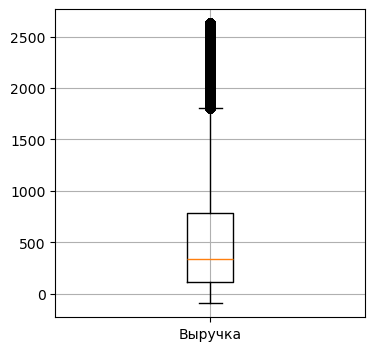

In [36]:
plt.figure(figsize=(4,4))
plt.boxplot(df['revenue_rub'], labels=['Выручка'])
plt.grid(True)
plt.show()


**Вывод по предобработке данных:** Создан новый столбец revenue_rub в котором пересчитали выручку в одной валюте - рубли.  
Пропуска обнаружены только в days_since_prev - 7.5%, NaN значения оставлены без изменений.  
Номинальные данные проверены, проведена нормализация.  
Отфильтрованы значения выручки по 99 перцентилю.

<a id="section-3"></a>
## 3.Создание профиля пользователя.

#### 3.1 Создание профиля для каждого пользователя.

В этом пункте будет создан профиль поведения для каждого пользователя с его агрегированными признаками.

Отсортируем данные по времени совершения заказа.

In [37]:
# Сортируем по пользователю и времени заказа
df = df.sort_values(['user_id', 'order_dt']).reset_index(drop=True)

In [38]:
first_order = df.groupby('user_id').first().reset_index()  # Первый заказ по времени
profile = first_order[['user_id', 'order_dt', 'device_type_canonical', 'region_name', 'service_name', 'event_type_main']].copy() # переносим данные в переменную
profile = profile.rename(columns={'order_dt': 'first_order_date'}) # меняем название колонки
# Выявляем дату последней покупки
last_order_date = df.groupby('user_id')['order_dt'].max().reset_index()
profile = profile.merge(last_order_date, on='user_id', how='left')
profile = profile.rename(columns={'order_dt': 'last_order_date'})
# Высчитываем количество покупок относительно каждого юзера
order_count = df.groupby('user_id').size().reset_index(name='total_orders')
profile = profile.merge(order_count, on='user_id', how='left')

In [39]:
avg_revenue = df.groupby('user_id')['revenue_rub'].mean().reset_index()
avg_revenue = avg_revenue.rename(columns={'revenue_rub': 'avg_revenue_per_order'})
profile = profile.merge(avg_revenue, on='user_id', how='left')

In [40]:
#Среднее количество билетов
avg_tickets = df.groupby('user_id')['tickets_count'].mean().reset_index()
avg_tickets = avg_tickets.rename(columns={'tickets_count': 'avg_tickets_per_order'})
profile = profile.merge(avg_tickets, on='user_id', how='left')

# Рассчитываем разницу между соседними заказами для каждого пользователя
df['time_diff'] = df.groupby('user_id')['order_dt'].diff()
# Переводим в дни (float)
df['time_diff_days'] = df['time_diff'].dt.total_seconds() / (24 * 3600)
# Среднее время между заказами (без учёта NaN — первого заказа в группе)
avg_time_between = df.groupby('user_id')['time_diff_days'].mean().reset_index()
avg_time_between = avg_time_between.rename(columns={'time_diff_days': 'avg_time_between_orders'})
profile = profile.merge(avg_time_between, on='user_id', how='left')


In [41]:
#Задаем бинарные признаки 
profile['is_two'] = (profile['total_orders'] >= 2).astype(int)
profile['is_five'] = (profile['total_orders'] >= 5).astype(int)

In [42]:
profile.head(5)

,user_id,first_order_date,device_type_canonical,region_name,service_name,event_type_main,last_order_date,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_time_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,mobile,Каменевский регион,край билетов,театр,2024-08-20,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,mobile,Каменевский регион,мой билет,выставки,2024-10-06,2,774.009979,3.000000,75.0,1,0
2,000898990054619,2024-07-13,mobile,Североярская область,лови билет!,другое,2024-10-23,3,767.213341,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,desktop,Каменевский регион,край билетов,театр,2024-08-15,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,mobile,Поленовский край,лучшие билеты,театр,2024-10-15,2,61.309998,1.500000,16.0,1,0


In [43]:
profile[profile['is_five'] == 1].head(5)

,user_id,first_order_date,device_type_canonical,region_name,service_name,event_type_main,last_order_date,total_orders,avg_revenue_per_order,avg_tickets_per_order,avg_time_between_orders,is_two,is_five
5,000cf0659a9f40f,2024-06-20,mobile,Широковская область,лови билет!,концерты,2024-06-21,13,1175.808500,3.307692,0.083333,1,1
13,002b75ca606ba46,2024-07-08,desktop,Каменевский регион,быстробилет,концерты,2024-10-16,6,443.580004,3.000000,20.000000,1,1
15,002ec276eee9b0b,2024-07-10,mobile,Широковская область,мой билет,концерты,2024-10-31,22,811.942723,2.863636,5.380952,1,1
16,0033403583a55ed,2024-06-19,mobile,Каменевский регион,билеты без проблем,другое,2024-09-17,6,135.692298,1.666667,18.000000,1,1
18,00345f897f95a34,2024-06-02,mobile,Лесодальний край,тебе билет!,концерты,2024-10-23,8,1338.258749,2.875000,20.428571,1,1


<a id="section-4"></a>
#### 3.2 Анализ полученных данных, проверка данных на репрезентативность и аномалии

Перед проводением исследовательского анализа данных и заключений выводов, важно понять, с какими данными работаем: насколько они репрезентативны и нет ли в них аномалий.

In [44]:
two_plus_orders = (profile['total_orders'] >= 2).mean() * 100
five_plus_orders = (profile['total_orders'] >= 5).mean() * 100
print(f'Количество пользователей: {len(profile)}') 
print(f'Cредняя выручка с одного заказа: {profile['avg_revenue_per_order'].mean():.2f}')
print(f'Доля пользователей с 2 и более заказами: {two_plus_orders:.2f}%')
print(f'Доля пользователей с 5 и более заказами: {five_plus_orders:.2f}%')

Количество пользователей: 21854
Cредняя выручка с одного заказа: 544.40
Доля пользователей с 2 и более заказами: 61.71%
Доля пользователей с 5 и более заказами: 29.01%


In [45]:
def print_stats(s, n, d=False):
    d = s.dropna() if d else s
    print(f"\n=== Статистика по {n} ===")
    for k, v in {
        'Среднее': d.mean(),
        'Медиана': d.median(),
        'Минимум': d.min(),
        'Максимум': d.max(),
        'Стандартное отклонение': d.std(),
        '25‑й перцентиль': d.quantile(0.25),
        '75‑й перцентиль': d.quantile(0.75)
    }.items():
        print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {int(v)}")

# Вызов
print_stats(profile['total_orders'], 'общему числу заказов')
print_stats(profile['avg_tickets_per_order'], 'среднему числу билетов в заказе')
print_stats(profile['avg_time_between_orders'], 'времени между заказами (дни)', True)



=== Статистика по общему числу заказов ===
Среднее: 13.17
Медиана: 2.00
Минимум: 1
Максимум: 10181
Стандартное отклонение: 121.67
25‑й перцентиль: 1.00
75‑й перцентиль: 5.00

=== Статистика по среднему числу билетов в заказе ===
Среднее: 2.74
Медиана: 2.75
Минимум: 1.00
Максимум: 11.00
Стандартное отклонение: 0.91
25‑й перцентиль: 2.00
75‑й перцентиль: 3.08

=== Статистика по времени между заказами (дни) ===
Среднее: 15.88
Медиана: 8.07
Минимум: 0.00
Максимум: 148.00
Стандартное отклонение: 22.27
25‑й перцентиль: 1.00
75‑й перцентиль: 20.50


<Axes: title={'center': 'До фильтрации'}>

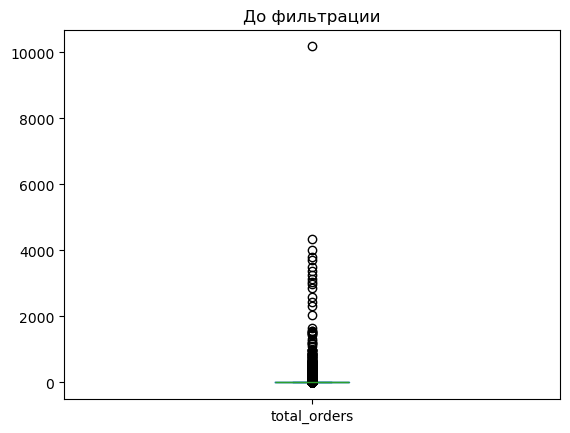

In [46]:
profile['total_orders'].plot(kind='box', title='До фильтрации')

Выводы по анализу данных: объём данных достаточен для базового анализа. данные по числу заказов содержат экстремальные выбросы, искажающие статистику, поэтому проведем фильтрацию по 95 процентилю.

In [47]:
threshold = profile['total_orders'].quantile(0.95)

# Фильтруем: оставляем только строки, где total_orders <= 95% значений
profile_clean = profile[profile['total_orders'] <= threshold].copy()

In [48]:
n_original = len(profile)
n_clean = len(profile_clean)
n_filtered = n_original - n_clean

print(f"Исходный объём данных: {n_original} пользователей")
print(f"Очищенный объём данных: {n_clean} пользователей")
print(f"Отфильтровано: {n_filtered} пользователей ({n_filtered / n_original * 100:.1f}%)")

Исходный объём данных: 21854 пользователей
Очищенный объём данных: 20761 пользователей
Отфильтровано: 1093 пользователей (5.0%)


После фильтраций убрано 1093 пользователей, сейчас выведем повторную статистику.

In [49]:
def print_stats(series, name, dropna=False):
    data = series.dropna() if dropna else series
    stats = {
        'Среднее': data.mean(),
        'Медиана': data.median(),
        'Минимум': data.min(),
        'Максимум': data.max(),
        'Стандартное отклонение': data.std(),
        '25‑й перцентиль': data.quantile(0.25),
        '75‑й перцентиль': data.quantile(0.75)
    }
    print(f"\n=== Статистика по {name} (очищенные данные) ===")
    for k, v in stats.items():
        print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {int(v)}")

# Выводим статистику для ключевых метрик на очищенном датасете
print_stats(profile_clean['total_orders'], 'общему числу заказов')
print_stats(profile_clean['avg_tickets_per_order'], 'среднему числу билетов в заказе')
print_stats(profile_clean['avg_time_between_orders'], 'времени между заказами (дни)', dropna=True)


=== Статистика по общему числу заказов (очищенные данные) ===
Среднее: 4.05
Медиана: 2.00
Минимум: 1
Максимум: 31
Стандартное отклонение: 5.11
25‑й перцентиль: 1.00
75‑й перцентиль: 5.00

=== Статистика по среднему числу билетов в заказе (очищенные данные) ===
Среднее: 2.74
Медиана: 2.75
Минимум: 1.00
Максимум: 11.00
Стандартное отклонение: 0.93
25‑й перцентиль: 2.00
75‑й перцентиль: 3.15

=== Статистика по времени между заказами (дни) (очищенные данные) ===
Среднее: 17.09
Медиана: 9.50
Минимум: 0.00
Максимум: 148.00
Стандартное отклонение: 22.84
25‑й перцентиль: 1.00
75‑й перцентиль: 22.25


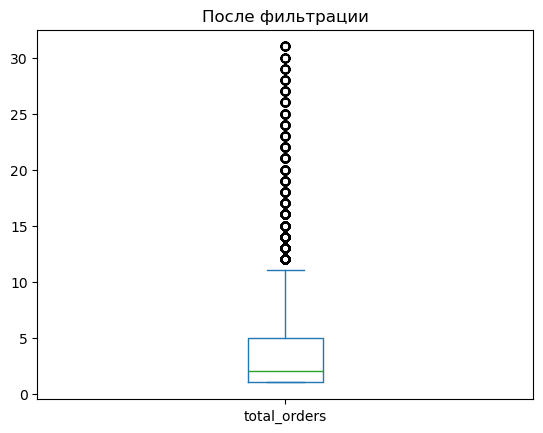

In [50]:
profile_clean['total_orders'].plot(kind='box', title='После фильтрации')
plt.show()


Вывод по данным: Убраны выбросы по количеству заказов, данные нормализованы, в остальном данные не требуют фильтраций. 

<a id="section-5"></a>
## 4. Исследовательский анализ данных

Будет проведено исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа.

#### 4.1 Создание сегментации с расчетом доли по четырем признакам: по типу их первого мероприятия, устройства, региону,  билетному оператору. Благодаря чему можно будет сделать выводы о равномерности распределений.

In [51]:

segment_columns = [
    'event_type_main',
    'device_type_canonical',
    'region_name',
    'service_name'
]
for col in segment_columns:
    print(f"\nГруппировка пользователей по {col}")
    
    # Подсчёт количества пользователей в каждом сегменте
    counts = profile_clean[col].value_counts(dropna=False)
    
    # Подсчёт процентов
    shares = profile_clean[col].value_counts(normalize=True, dropna=False) * 100
    
    
    # Объединяем в один DataFrame
    result = pd.DataFrame({
        'Количество': counts,
        'Доля (%)': shares.round(2)
    })
    
    print(result)
    print(f"Всего сегментов: {len(counts)}")
    print(f"Общее число пользователей: {counts.sum()}")


Группировка пользователей по event_type_main
                 Количество  Доля (%)
event_type_main                      
концерты               9193     44.28
другое                 5170     24.90
театр                  4072     19.61
стендап                1073      5.17
спорт                   765      3.68
выставки                396      1.91
ёлки                     92      0.44
Всего сегментов: 7
Общее число пользователей: 20761

Группировка пользователей по device_type_canonical
                       Количество  Доля (%)
device_type_canonical                      
mobile                      17198     82.84
desktop                      3563     17.16
Всего сегментов: 2
Общее число пользователей: 20761

Группировка пользователей по region_name
                          Количество  Доля (%)
region_name                                   
Каменевский регион              6778     32.65
Североярская область            3599     17.34
Широковская область             1189      5.73
Озе

В каждом из признаков есть доминирующий сегмент, наиболее выраженный это тип устройства с которого был куплен первый билет : мобильное устройство которым воспользовались почти 83% клиентов. Стоит отметить еще тип ивента Концерты, который охватывает почти половину всех покупок, а именно 44%.

<a id="section-6"></a>
#### 4.2 Анализ возвращения пользователя к ресурсу

Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа. Определим Топ10 относительно каждого сегмента. 

In [52]:
returners = {} #
for col in segment_columns:
    print(f"\nДоля пользователей вернувшихся в сегменте {col} ")
    
    # Группируем по сегменту и считаем:
    grouped = profile_clean.groupby(col).agg(
        total_users=('user_id', 'count'),
        two_plus_orders=('is_two', 'sum')  # is_two == 1, если total_orders ≥ 2
    ).reset_index()
    
    # Доля пользователей с ≥ 2 заказами (в %)
    grouped['percent_two_plus_orders'] = (grouped['two_plus_orders'] / grouped['total_users']) * 100
    grouped['percent_two_plus_orders'] = grouped['percent_two_plus_orders'].round(2)  # Округляем до 2 знаков
    
    # Сортируем по общему числу пользователей по убыванию
    grouped_returners = grouped.sort_values('total_users', ascending=False)
    
    
    # Сохраняем результат
    returners[col] = grouped_returners
    
    print(grouped_returners[[col, 'total_users', 'two_plus_orders', 'percent_two_plus_orders']].head(10))
    print(f"Всего сегментов: {len(grouped)}")


Доля пользователей вернувшихся в сегменте event_type_main 
  event_type_main  total_users  two_plus_orders  percent_two_plus_orders
2        концерты         9193             5544                    60.31
1          другое         5170             2979                    57.62
5           театр         4072             2520                    61.89
4         стендап         1073              639                    59.55
3           спорт          765              414                    54.12
0        выставки          396              247                    62.37
6            ёлки           92               50                    54.35
Всего сегментов: 7

Доля пользователей вернувшихся в сегменте device_type_canonical 
  device_type_canonical  total_users  two_plus_orders  percent_two_plus_orders
1                mobile        17198            10174                    59.16
0               desktop         3563             2219                    62.28
Всего сегментов: 2

Доля пользоват

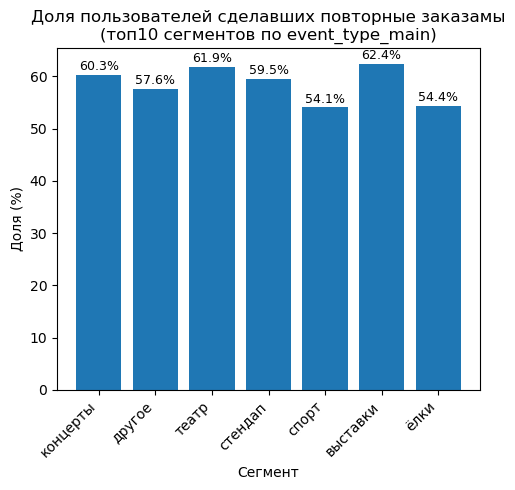

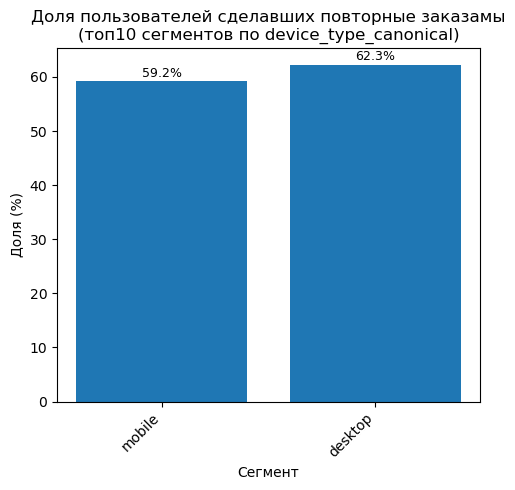

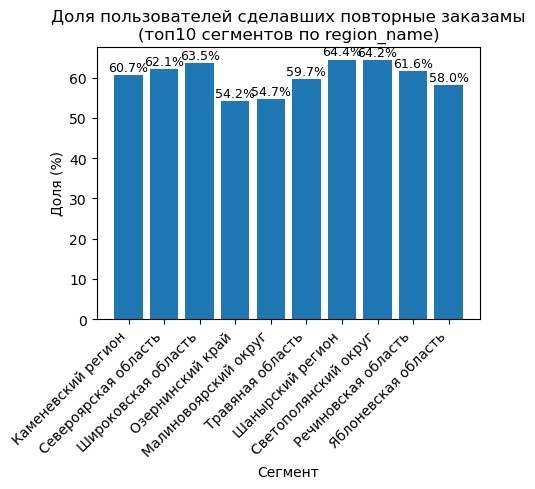

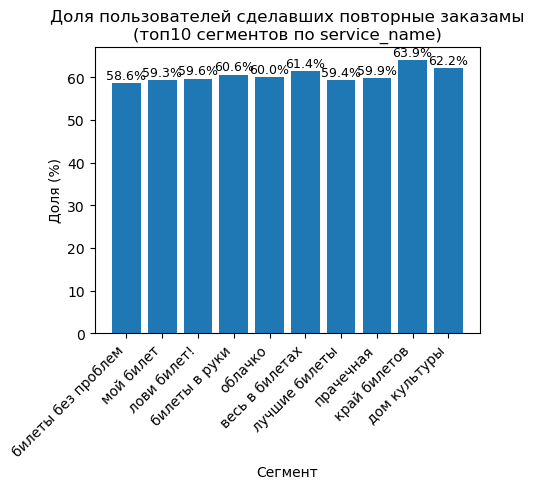

In [53]:
def plot_top10(data, column_name): #Функция по созданию столбчатой диаграммы по каждому сегменту
    top10 = data.head(10)
    
    plt.figure(figsize=(5, 5))
    bars = plt.bar(top10[column_name], top10['percent_two_plus_orders'])
    
    plt.title(f'Доля пользователей сделавших повторные заказамы\n(топ10 сегментов по {column_name})')
    plt.xlabel('Сегмент')
    plt.ylabel('Доля (%)')
    plt.xticks(rotation=45, ha='right')
    
    # Добавляем значения над столбцами
    for bar, value in zip(bars, top10['percent_two_plus_orders']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Рисуем графики для каждого признака
for col in segment_columns:
    if len(returners[col]) > 0:
        plot_top10(returners[col], col)


**Выводы по возврещениям:** Процент удержания клиентов относительно всех сегментов находится в районе 55-65%. Можно высказать по несколько мнений относительно каждого сегмента.
По типу мероприятия пользователи, начавшие с выставок, театра или концерта возвращаются заметно чаще.
Десктопные пользователи чуть лояльнее мобильных.
Есть регионы с ощутимо высокой лояльностью (63–64 %).
Некоторые операторы привлекают более лояльных пользователей (до 64 %).

**проверим продуктовые гипотезы:** <br>
***Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.***<br>
<div class="alert alert-block alert-info">
<b>Гипотеза 1 неверна, пользователи купишвие первый билет на концерт возвращаются чаще, нежели купившие на спорт события, разница более чем на 6%. </b> </div>
***Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.***<br>

<div class="alert alert-block alert-info">
<b>Гипотеза не совсем четкая, однозначного ответа быть не может. Процент возвращения примерно равный если сравнивать первый в рейтинге регион с топ10 регионом, то да гипотеза подтвердится, но если брать топ9 регион то гипотеза окажется ложной. И то разница между ними примерно в 2-3%.  </b> </div>

<a id="section-7"></a>
### 4.3 Исследование поведения пользователей через показатели выручки и состава заказа

На данном этапе изучим количественные характеристики пользователей

Изучим выручку с пользовтелей совершивших всего одну покупку и тех кто совершил более двух раз.

Пользователей с 1 заказом: 8368
Пользователей с ≥2 заказами: 12393


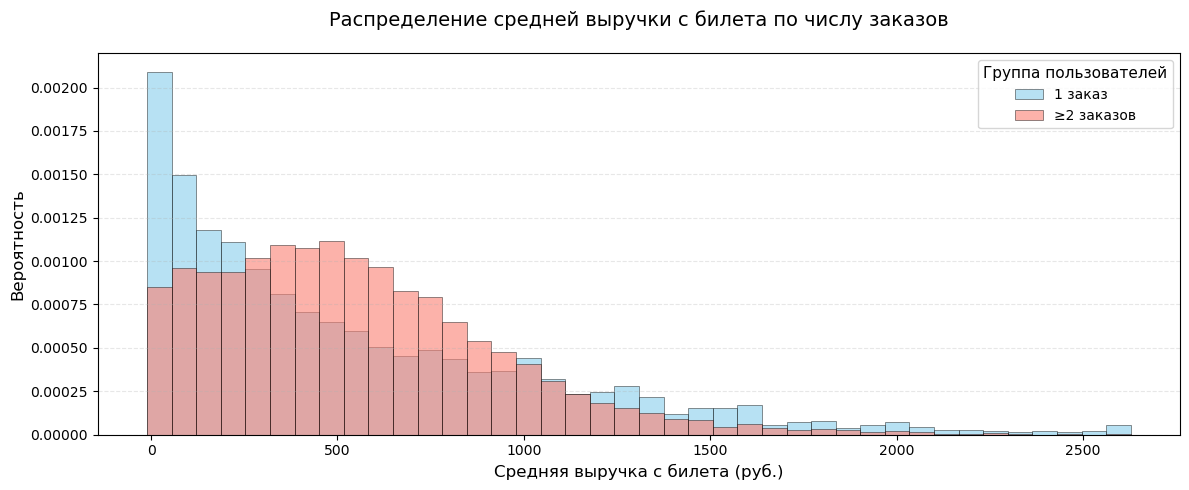

In [54]:
one_order = profile_clean[profile_clean['total_orders'] == 1] # Создаем две группы с одним и более заказами
two_plus_orders = profile_clean[profile_clean['total_orders'] >= 2]


# Проверяем, что данные есть в обеих группах
print(f"Пользователей с 1 заказом: {len(one_order)}")
print(f"Пользователей с ≥2 заказами: {len(two_plus_orders)}")

# Определяем общие границы и количество интервалов
all_values = profile_clean['avg_revenue_per_order'].dropna()
bins = 40  # Можно изменить на нужное число интервалов
xmin, xmax = all_values.min(), all_values.max()


# Строим гистограммы
plt.figure(figsize=(12, 5))

plt.hist(
    one_order['avg_revenue_per_order'],
    bins=bins,
    range=(xmin, xmax),
    alpha=0.6,
    density=True,
    label='1 заказ',
    color='skyblue',
    edgecolor='black',
    linewidth=0.5
)

plt.hist(
    two_plus_orders['avg_revenue_per_order'],
    bins=bins,
    range=(xmin, xmax),
    alpha=0.6,
    density=True,
    label='≥2 заказов',
    color='salmon',
    edgecolor='black',
    linewidth=0.5
)

# Оформляем график
plt.title('Распределение средней выручки с билета по числу заказов', fontsize=14, pad=20)
plt.xlabel('Средняя выручка с билета (руб.)', fontsize=12)
plt.ylabel('Вероятность', fontsize=12)
plt.legend(title='Группа пользователей', title_fontsize=11, fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()


# Показываем график
plt.show()

Концентрация пользователей: Сделавшие один заказ собраны в районе 0-250. <br>
Клиенты совершившие более двух заказов сконцентрированы примерно на выручке 500. <br>
Различия между группами очевидно есть, характерным поведением для постоянного клиента приносить выручку с каждого заказа в районе 500. А единичные покупки приносили минимальную прибыль, но стоит отметить что выручки приносившие более 1300 чаще оформлялись именно единичными покупателями. 

**Изучим выручку Клиентов соврешивших 2-4 и 4+ заказа**

Пользователей с 2–4 заказами: 7147
Пользователей с ≥5 заказами: 5246


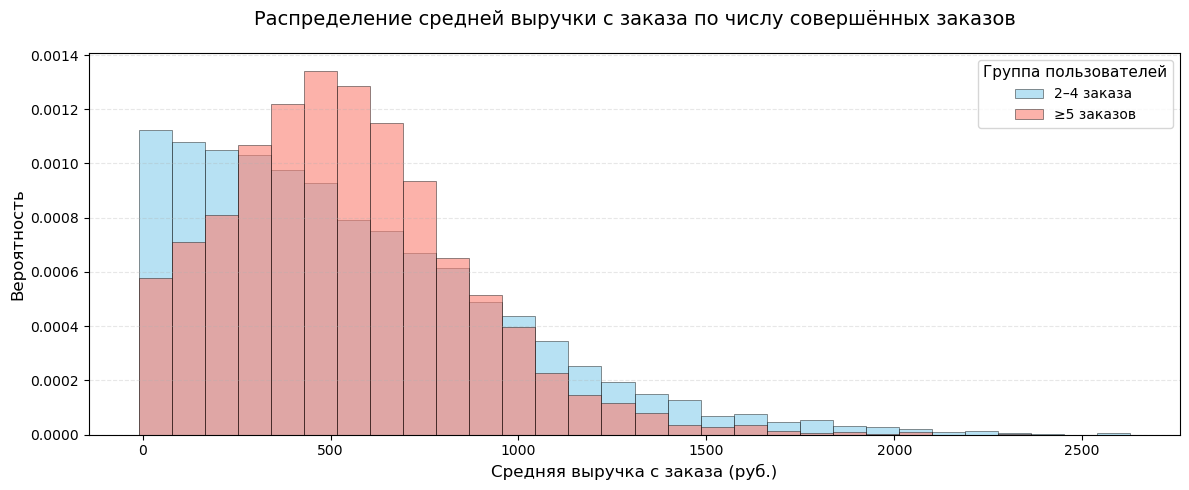

In [55]:
group_2to4 = profile_clean[
    (profile_clean['total_orders'] >= 2) & 
    (profile_clean['total_orders'] <= 4)
]

group_5plus = profile_clean[
    profile_clean['total_orders'] >= 5
]

# Проверяем численность групп
print(f"Пользователей с 2–4 заказами: {len(group_2to4)}")
print(f"Пользователей с ≥5 заказами: {len(group_5plus)}")


# Определяем общие границы и число интервалов
all_values = profile_clean['avg_revenue_per_order'].dropna()
bins = 30
xmin, xmax = all_values.min(), all_values.max()

# Строим гистограммы
plt.figure(figsize=(12, 5))

plt.hist(
    group_2to4['avg_revenue_per_order'],
    bins=bins,
    range=(xmin, xmax),
    alpha=0.6,
    density=True,
    label='2–4 заказа',
    color='skyblue',
    edgecolor='black',
    linewidth=0.5
)

plt.hist(
    group_5plus['avg_revenue_per_order'],
    bins=bins,
    range=(xmin, xmax),
    alpha=0.6,
    density=True,
    label='≥5 заказов',
    color='salmon',
    edgecolor='black',
    linewidth=0.5
)

# Оформляем график
plt.title('Распределение средней выручки с заказа по числу совершённых заказов', fontsize=14, pad=20)
plt.xlabel('Средняя выручка с заказа (руб.)', fontsize=12)
plt.ylabel('Вероятность', fontsize=12)
plt.legend(title='Группа пользователей', title_fontsize=11, fontsize=10)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Показываем график
plt.show()

In [56]:
# Статистика в цифрах 
stats = pd.DataFrame({
    'Группа': ['2–4 заказа', '≥5 заказов'],
    'Среднее (руб.)': [
        group_2to4['avg_revenue_per_order'].mean(),
        group_5plus['avg_revenue_per_order'].mean()
    ],
    'Медиана (руб.)': [
        group_2to4['avg_revenue_per_order'].median(),
        group_5plus['avg_revenue_per_order'].median()
    ],
    'Стд. откл. (руб.)': [
        group_2to4['avg_revenue_per_order'].std(),
        group_5plus['avg_revenue_per_order'].std()
    ],
    'Объём выборки': [
        len(group_2to4),
        len(group_5plus)
    ]
})

print(stats.round(2))


       Группа  Среднее (руб.)  Медиана (руб.)  Стд. откл. (руб.)  \
0  2–4 заказа          551.57          471.27             420.20   
1  ≥5 заказов          542.22          514.58             314.11   

   Объём выборки  
0           7147  
1           5246  


Различия между этими двумя группами выявлены, средняя выручка на 9 единиц больше у клиентов которые делали заказы 2-4 раза. Но медиана 43 больше у людей с 5+ заказами. Это обосновывается тем что покупки с более высокой выручкой делали именно группа 2-4.

<a id="section-8"></a>
### 4.4 Влияние среднего количества билетов на вероятность повторной покупки.

Проанализируем возможность вляния возвращения клиентов из-за количества заказанных билетов.

Сегментация по среднему количеству билетов в заказе:
       segment  total_users  repeat_orders  repeat_rate_%
0   1–2 билета         2415           1237           51.2
1   2–3 билета         8759           6250           71.4
2  3–5 билетов         8926           4782           53.6
3   5+ билетов          661            124           18.8


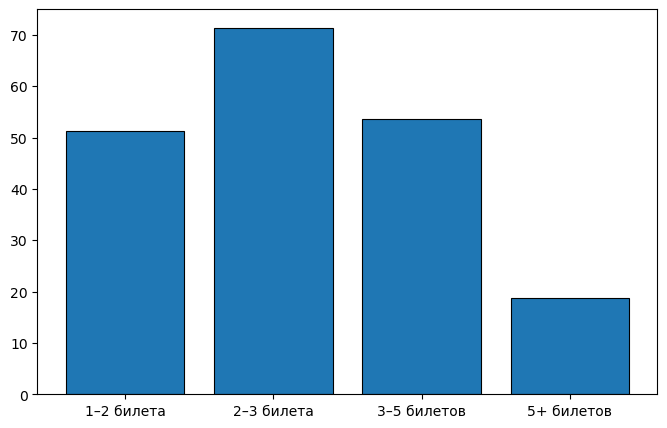

In [57]:
# 1. Создаём сегменты
def get_segment(tickets):
    if 1 <= tickets < 2:
        return '1–2 билета'
    elif 2 <= tickets < 3:
        return '2–3 билета'
    elif 3 <= tickets < 5:
        return '3–5 билетов'
    else:  # tickets >= 5
        return '5+ билетов'

profile_clean['segment'] = profile_clean['avg_tickets_per_order'].apply(get_segment)

# 2. Считаем метрики по сегментам
result = profile_clean.groupby('segment').agg(
    total_users=('user_id', 'count'),
    repeat_orders=('is_two', 'sum')  # is_two == 1 для ≥2 заказов
).reset_index()

# 3. Считаем долю повторных заказов (%)
result['repeat_rate_%'] = (result['repeat_orders'] / result['total_users']) * 100
result['repeat_rate_%'] = result['repeat_rate_%'].round(1)  # Округляем до 1 знака

# 4. Выводим результат
print("Сегментация по среднему количеству билетов в заказе:")
print(result)
plt.figure(figsize=(8, 5))
bars = plt.bar(
    result['segment'],
    result['repeat_rate_%'],
    edgecolor='black',
    linewidth=0.8
)
plt.show()

Пользователи распределены сконцентрированно, подавляющее большинство у 2-3 и 3-5 билетов примерно 8800, довольно низкое количество у 5+ всего 661. <br>
71% пользователей возвращается совершивших покупку 2-3 билетов, что говорит о очень высокой вероятности возвращения клиентом к сервису.
Низкое число пользователей в сегменте 5+ билетов (661) требует осторожности при экстраполяции данных. Например, низкий уровень повторных заказов (18,8 %) может отражать не реальную тенденцию, а специфику узкой группы(возможно были закупки для корп. клиентов или всяких массовых покупок)

<a id="section-9"></a>
### 4.5 Исследование временных характеристик первого заказа и их влияния на повторные покупки

На данном этапе изучим параметры времени: день недели; лайфтайм; ср.интервал покупок 

#### 4.5.1 Анализ дня недели

Влияние дня недели первой покупки на повторные заказы:
  weekday_name  total_users  repeat_buyers  repeat_rate_%
1       Monday         2820           1737           61.6
5      Tuesday         3025           1815           60.0
6    Wednesday         2960           1804           60.9
4     Thursday         3027           1764           58.3
0       Friday         3166           1857           58.7
2     Saturday         3122           1885           60.4
3       Sunday         2641           1531           58.0


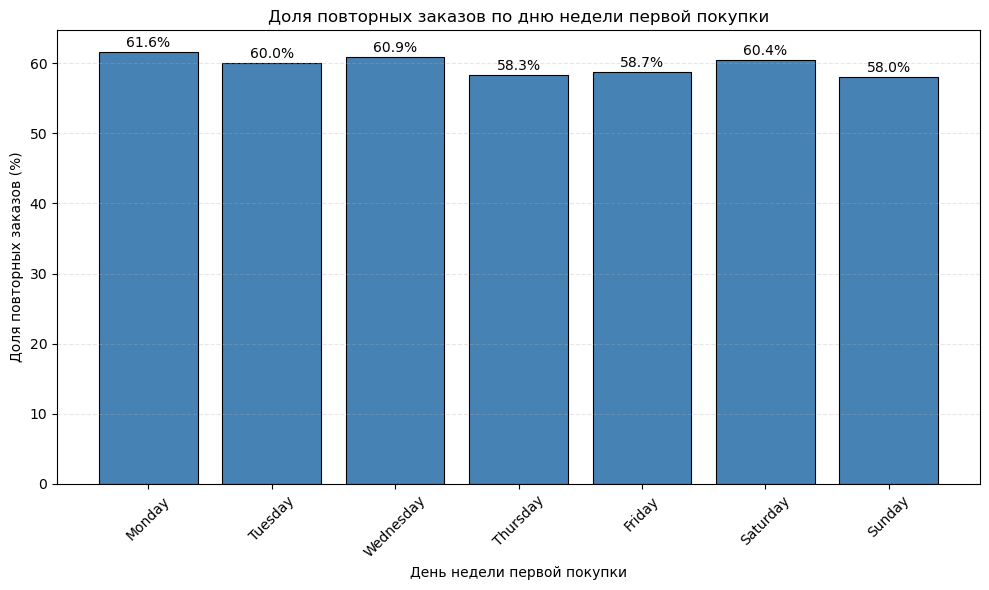

In [58]:
# 1. Извлекаем день недели из даты первого заказа
profile_clean['weekday'] = profile_clean['first_order_date'].dt.dayofweek  # Цифровое отображения дня недели 0=Понедельник, 6=Воскресенье
profile_clean['weekday_name'] = profile_clean['first_order_date'].dt.day_name()

# 2. Группируем по дню недели и считаем метрики
result = profile_clean.groupby('weekday_name').agg(
    total_users=('user_id', 'count'),
    repeat_buyers=('is_two', 'sum')  # is_two == 1 для ≥2 заказов
).reset_index()

# 3. Считаем долю повторных заказов в цифре
result['repeat_rate_%'] = (result['repeat_buyers'] / result['total_users']) * 100
result['repeat_rate_%'] = result['repeat_rate_%'].round(1)

# 4. Сортируем дни недели в правильном порядке
days_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
    'Friday', 'Saturday', 'Sunday'
]
result['weekday_name'] = pd.Categorical(
    result['weekday_name'],
    categories=days_order,
    ordered=True
)
result = result.sort_values('weekday_name')


print("Влияние дня недели первой покупки на повторные заказы:")
print(result)

# график дня недели
plt.figure(figsize=(10, 6))
bars = plt.bar(
    result['weekday_name'],
    result['repeat_rate_%'],
    color='steelblue',
    edgecolor='black',
    linewidth=0.8
)

plt.title('Доля повторных заказов по дню недели первой покупки')
plt.xlabel('День недели первой покупки')
plt.ylabel('Доля повторных заказов (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# цифровые значения сверху над столбиками
for bar, value in zip(bars, result['repeat_rate_%']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.3,
        f'{value}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.show()

Следуя информации по графикам, можно сказать что вероятность возврата клиента не существенно зависит от дня недели. Разница между самым большим процентом и низшим не достигает и 4%. 

#### 4.5.2 Cредний интервал между заказами влияет ли на удержание клиентов.

Сравнение среднего времени между заказами по группам:
       Группа  Среднее время между заказами (дни)  Число пользователей
0  2–4 заказа                               21.41                 7147
1  5+ заказов                               11.20                 5246


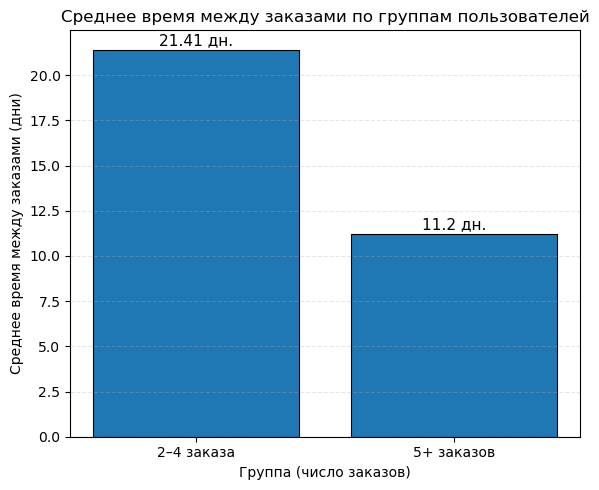

In [59]:
#  Вычисляем среднее время между заказами для каждой группы
mean_time_2to4 = group_2to4['avg_time_between_orders'].mean()
mean_time_5plus = group_5plus['avg_time_between_orders'].mean()


# Формируем итоговую таблицу
result = pd.DataFrame({
    'Группа': ['2–4 заказа', '5+ заказов'],
    'Среднее время между заказами (дни)': [
        round(mean_time_2to4, 2),
        round(mean_time_5plus, 2)
    ],
    'Число пользователей': [
        len(group_2to4),
        len(group_5plus)
    ]
})

print("Сравнение среднего времени между заказами по группам:")
print(result)


# Строим столбчатый график
plt.figure(figsize=(6, 5))
bars = plt.bar(
    result['Группа'],
    result['Среднее время между заказами (дни)'],
    edgecolor='black',
    linewidth=0.8
)

plt.title('Среднее время между заказами по группам пользователей')
plt.xlabel('Группа (число заказов)')
plt.ylabel('Среднее время между заказами (дни)')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()


# Добавляем значения над столбцами
for bar, value in zip(bars, result['Среднее время между заказами (дни)']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.1,
        f'{value} дн.',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.show()


Заметная разница видна зависимости среднего интервала к количеству совершенных ими заказами. Если клиент закупает билеты чаще по времени, то вероятность совершения ими более 5 заказов возрастает. 

<a id="section-10"></a>
### 4.6 Корреляционный анализ количества покупок и признаков пользователя

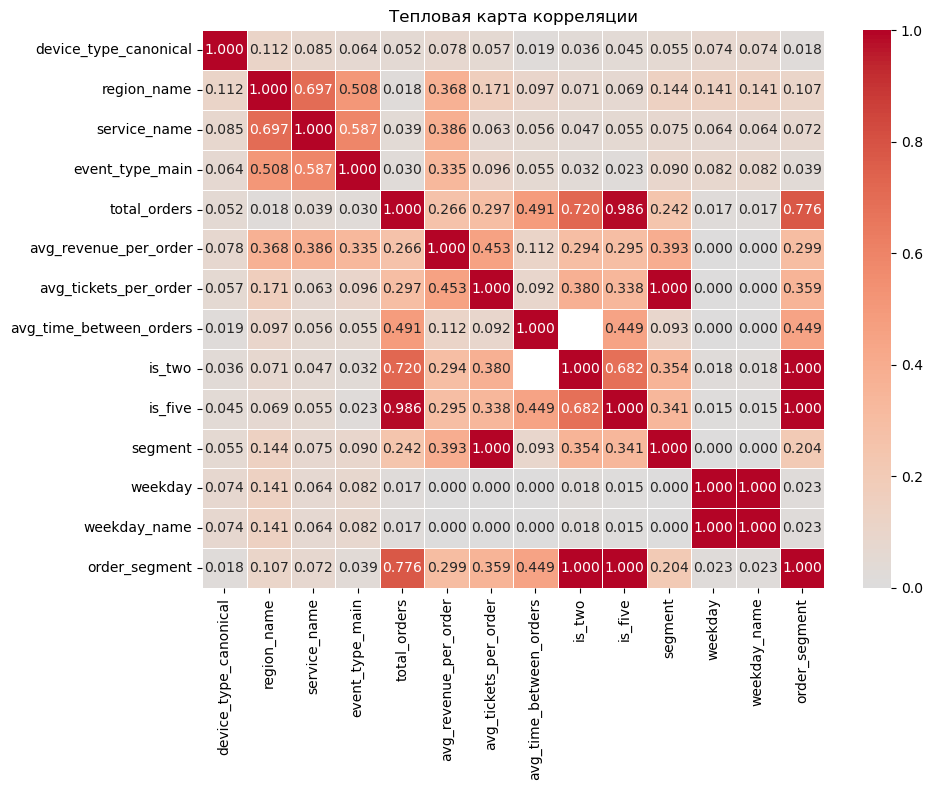


 связанные с total_orders признаки:
is_five                    0.986
order_segment              0.776
is_two                     0.720
avg_time_between_orders    0.491
avg_tickets_per_order      0.297
Name: total_orders, dtype: float64

 связанные с сегментом (1/2–4/5+) признаки :
is_two                     1.000
is_five                    1.000
total_orders               0.776
avg_time_between_orders    0.449
avg_tickets_per_order      0.359
Name: order_segment, dtype: float64


In [60]:
# Создаём сегмент по числу заказов
def get_segment(n):
    if n == 1:
        return '1 заказ'
    elif 2 <= n <= 4:
        return '2–4 заказа'
    else:
        return '5+ заказов'

profile_clean['order_segment'] = profile_clean['total_orders'].apply(get_segment)

# Определяем интервальные столбцы 
interval_cols = [
    'total_orders',
    'avg_revenue_per_order',
    'avg_tickets_per_order',
    'avg_time_between_orders'
]

# Список признаков для анализа (без дат и user_id)
cols = [
    col for col in profile_clean.columns
    if col not in ['user_id', 'first_order_date', 'last_order_date']
]

# Корреляция φₖ с total_orders и order_segment
phik_matrix = profile_clean[cols].phik_matrix(interval_cols=interval_cols, bins=10)

# Выводим тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Тепловая карта корреляции')
plt.tight_layout()
plt.show()

# 7. Корреляции с total_orders (топ-5)
print("\n связанные с total_orders признаки:")
corr_total = phik_matrix['total_orders'].sort_values(ascending=False)
corr_total = corr_total[corr_total.index != 'total_orders']  # без самокорреляции
print(corr_total.head(5).round(3))

# 8. Корреляции с order_segment (топ-5)
print("\n связанные с сегментом (1/2–4/5+) признаки :")
corr_segment = phik_matrix['order_segment'].sort_values(ascending=False)
corr_segment = corr_segment[corr_segment.index != 'order_segment']
print(corr_segment.head(5).round(3))

Корреляции связанные с total_orders самые сильные это конечно же количество заказов совершенным одним пользователем 5+ и 2+. 
Так же количество заказов коррелирует со средним временем показывая результат 0.49 что говорит о умеренной связи, чем чаще относительно временного интервала пользователеь делает заказы, тем больше увеличивается общее число заказов.

<a id="section-11"></a>
## 5.Выводы и рекомендации

Данные получены с 4 разных таблиц путем внутреннего соединения. Сумма выручки переведена с разных валют в единую путем расчета актуального курса в день совершения транзакции. В данных были выбросы их отфильтровали по 95 процентилю из-за невозможности уточнения достоверности данных. <br>
Общее количество пользователей в выборке: 21854(доля пользователей с 2 и более заказами: 61.71%, а так же доля пользователей с 5 и более заказами: 29.01)%
По типу мероприятия пользователи, начавшие с выставок, театра или концерта возвращаются заметно чаще. Десктопные пользователи чуть лояльнее мобильных (более чем на 3%). Есть регионы с ощутимо высокой лояльностью (63–64 %): Шантырский, Светополянский, Широковская обл.. Некоторые операторы привлекают более лояльных пользователей (до 64 %) - лидер "Край билетов". <br>

Выручка больше для пользователей совершивших 2+ заказа, нежели для клиентов с одним заказом. <br>
Концентрация пользователей: Сделавшие один заказ собраны в районе 0-250. <br>
Клиенты совершившие более двух заказов сконцентрированы примерно на выручке 500 <br> 
Так же обнаружена очень высокая вероятность возвращения клиентов купивших 2-3 билета, составляющее ~71%. В противовес имеются очень низкие показатели возврата пользователей купивших 5+ билетов, но тут стоит учитывать очень малое количество пользователей (661 из 21854 возможных), что означает возможность искажения реальной тенденции. в Остальных категорях билетного количества примерно равна 53% <br>
Важную роль на количество заказов влияет среднее время интервалов между покупками, чем мень время интервала, тем больше количество заказов совершают пользователи. <br>
Относительно корреляции так же играет существенную роль среднее время между покупками и количество купленных билетов в заказе..

**Рекомендации:** Стоит усилить общую долю пользователей совершивших 2+ заказа. Для этого стоило бы: <br>
1- Разобраться с вопросом низкого процента возврата пользователей совершивших покупку более 5 билетов. Может стоит ввести акции или скидки на покупки более 5 билетов единовременно, изучить стратегии работы с такими случаями у конкурентов, что они предлагают в таких случаях.  <br>
2- Оптимизировать/улучшить мобильное приложение  <br>
3- Изучить факторы успеха определенных регионов, возможно усилить маркетинг в отстающих регионах.  <br>
4- Обратить внимание на временные паттерны, стимулировать пользователей покупать билеты чаще, возможно предлагать акции через N время последней покупки, а для бездействующих пользователей делать рассылки/уведомления.